In [1]:
import dask_gateway

cluster = dask_gateway.GatewayCluster()
client = cluster.get_client()
cluster.scale(40)
print(cluster.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.275532be781f41c0845de5a8bb3b4b4d/status


In [2]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12,8

In [89]:
year = 1998
arr3d = np.load(f'./arr_heat3d/arr_heat3d-{year}.npy')

np.where(arr==1) # pre-labeled heat events

(array([122, 122, 122, ..., 267, 267, 267]),
 array([498, 498, 498, ...,  39,  39,  40]),
 array([240, 241, 242, ...,  77,  78,  77]))

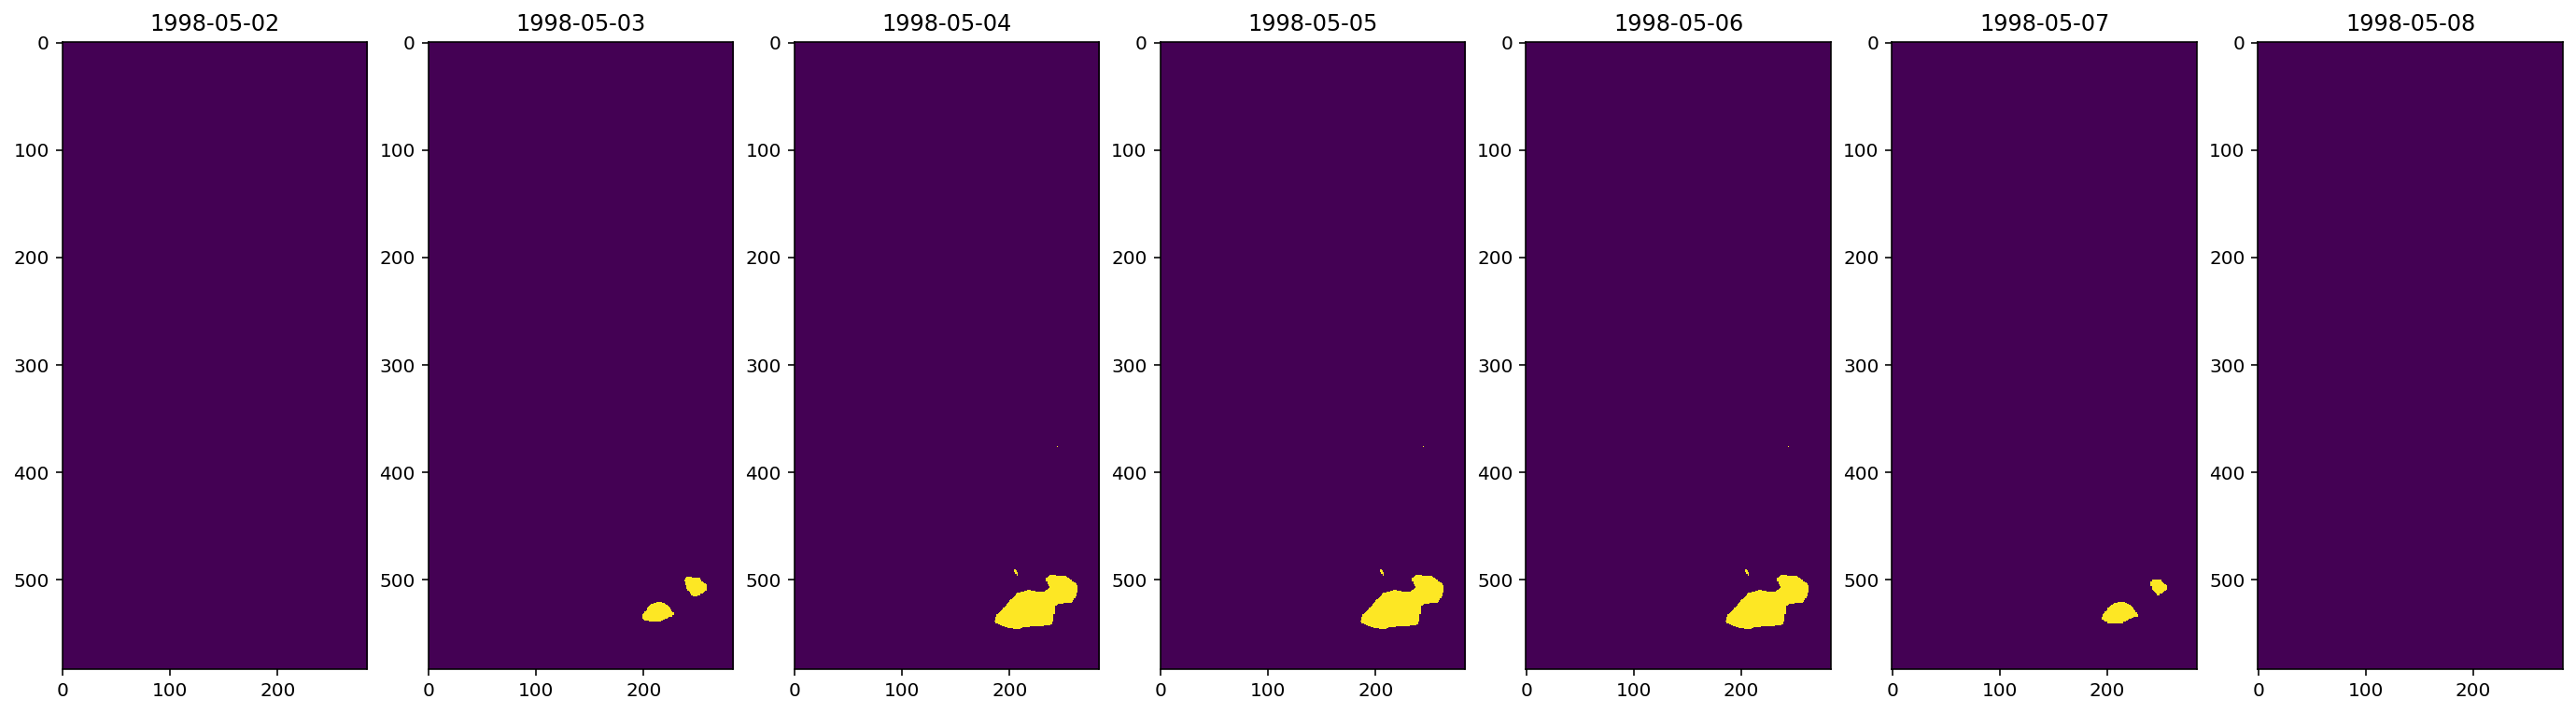

In [90]:
################################
# progress of an example heat event
################################

t_indexes = range(121,128)

dr = pd.date_range(start=f'1/1/{year}', periods=365, freq='D').date

fig, axs = plt.subplots(1, len(t_indexes), figsize=(24,12))

for i, idx in enumerate(t_indexes):
    H = arr3d[idx,:,:]
    ax = axs.ravel()[i]
    ax.imshow(H, interpolation='none')
    ax.set_title(dr[idx])


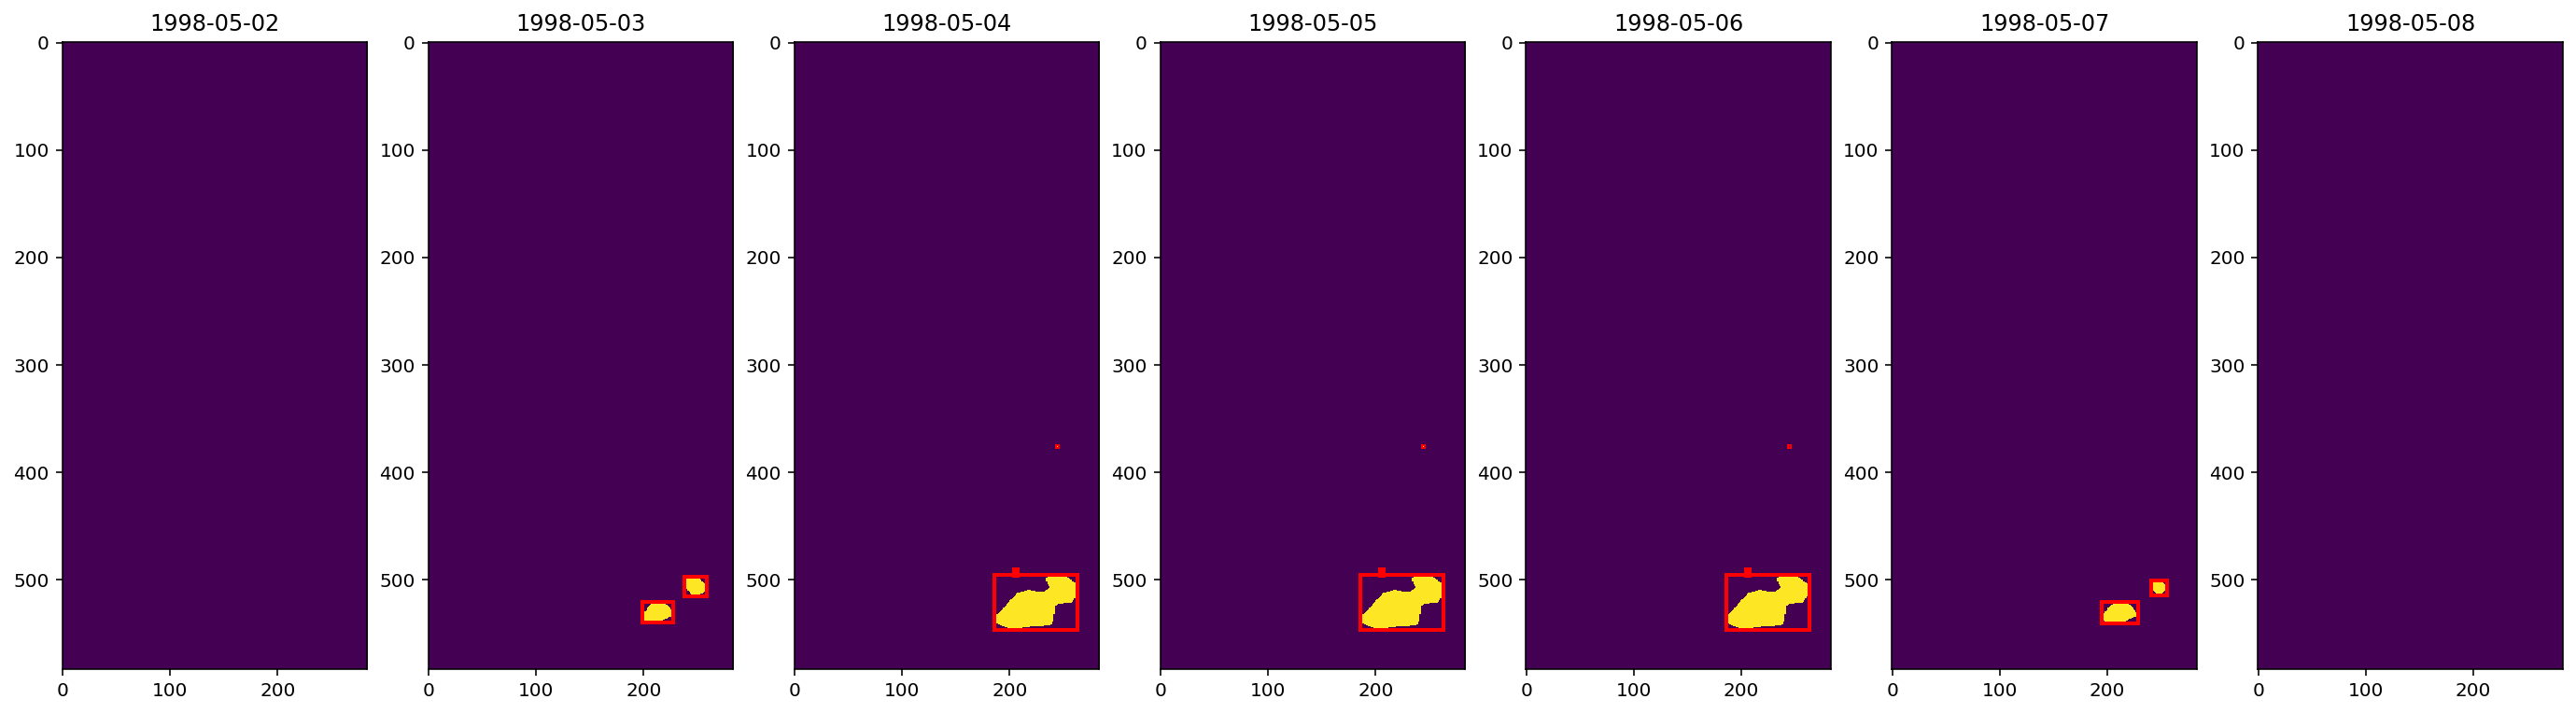

In [93]:
################################
# find boundary boxes 
################################

# uses parent-child hierarchy to merge small areas into fewer heat events
# runs for a single time slice (day)
# later, we will find a way to fuse these boundary bozes in time axis (3rd dimension)
# to find our objective: 'heat events' in 3d, 
# defined by ((x1,y1),(x2,y2),(x3,y3),(x4,y4),(t1,t2)) 3d slices

# !pip install opencv-python-headless
import cv2
from matplotlib.patches import Rectangle
from typing import List, Tuple

def draw_boxes(arr2d: np.array) -> List[Tuple[int,int,int,int]]:
    
    H = arr2d.astype(np.uint8)
    _, thresh = cv2.threshold(H, 0, 1, 0)
    contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    
    corners = [cv2.boundingRect(c) for c in contours]
    
    return corners


fig, axs = plt.subplots(1, len(t_indexes), figsize=(24,12))

for i, idx in enumerate(t_indexes):
    
    arr2d = arr3d[idx,:,:]
    
    ax = axs.ravel()[i]
    ax.imshow(arr2d, interpolation='none')
    ax.set_title(dr[idx])
    
    corners = draw_boxes(arr2d)
    for c in corners:
        x,y,w,h = c
        rect = Rectangle((x, y), w, h, color='red', fill=False, linewidth=2)
        ax.add_patch(rect)
    

In [5]:
# # !pip install opencv-python-headless
# import cv2

# H = arr[123,:,:].astype(np.uint8)
# gray = cv2.cvtColor(H, cv2.COLOR_GRAY2BGR)
# thresh = cv2.threshold(gray,128,255, cv2.THRESH_BINARY)[1]

# result = H.copy()
# contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# contours = contours[0] if len(contours) == 2 else contours[1]
# for cntr in contours:
#     x,y,w,h = cv2.boundingRect(cntr)
#     cv2.rectangle(result, (x, y), (x+w, y+h), (0, 0, 255), 2)
#     print("x,y,w,h:",x,y,w,h)


In [6]:
# H = arr[123,:,:].astype(np.uint8)
# gray = cv2.cvtColor(H, cv2.COLOR_BGR2GRAY)
# # thresh = cv2.threshold(gray,128,255, cv2.THRESH_BINARY)[1]
# # cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [8]:
# import cv2
# H = arr[123,:,:].astype(np.uint8)
# detector = cv2.SimpleBlobDetector()

# # keypoints = detector.detect(H)
# from PIL import Image
# from keras.preprocessing.image import array_to_img

# img = array_to_img(H)
# detector.detect(img)